In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from wordfreq import top_n_list
from scraper import WikiScraper
from manager import DataManager

# Funkcja oceniająca dopasowanie tekstu do języka
def lang_confidence_score(word_counts, language_top_words):
    if not language_top_words:
        return 0.0
    text_words_set = set(word_counts.keys())
    lang_words_set = set(language_top_words)
    intersection = text_words_set.intersection(lang_words_set)
    return len(intersection) / len(lang_words_set)

print("Funkcja załadowana!")

Funkcja załadowana!


In [10]:
# Konfiguracja eksperymentu
languages = ['en', 'pl', 'ko']
k_values = [3, 10, 100, 1000]   # Różne wielkości próbek słów

# Pobieramy najczęstsze słowa dla każdego języka
data_lang = {lang: {} for lang in languages}
for lang in languages:
    for k in k_values:
        data_lang[lang][k] = top_n_list(lang, k)

print("Listy słów pobrane (Angielski, Polski, Koreański).")

Listy słów pobrane (Angielski, Polski, Koreański).


In [11]:
# Funkcje pomocnicze
def get_wiki_counts(phrase):
    try:
        scraper = WikiScraper(phrase)
        words = scraper.get_all_words()
        counts = {}
        for w in words:
            counts[w] = counts.get(w, 0) + 1
        return counts
    except Exception as e:
        print(f"Błąd przy {phrase}: {e}")
        return {}

def get_text_counts(text):
    import re
    words = re.findall(r'\w{2,}', text.lower())
    counts = {}
    for w in words:
        counts[w] = counts.get(w, 0) + 1
    return counts

# Dane do analizy
wiki_long = get_wiki_counts("Red Velvet")
wiki_bad = get_wiki_counts("Gee")

# Teksty spoza wiki
text_en_raw = "Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability."
text_pl_raw = "W Szczebrzeszynie chrząszcz brzmi w trzcinie i Szczebrzeszyn z tego słynie. Język polski jest trudny."

# Przykładowy tekst po koreańsku
text_ko_raw = "케이팝은 대한민국의 대중가요이다 케이팝은 전 세계적으로 인기를 끌고 있다 방탄소년단과 블랙핑크가 유명하다"

samples = {
    "Wiki: Artykuł Długi (K-pop)": wiki_long,
    "Wiki: Artykuł Krótki (Piosenka)": wiki_bad,
    "Tekst kontrolny: Angielski": get_text_counts(text_en_raw),
    "Tekst kontrolny: Polski": get_text_counts(text_pl_raw),
    "Tekst kontrolny: Koreański": get_text_counts(text_ko_raw)
}

print(f"Pobrano dane.")

Pobrano dane.


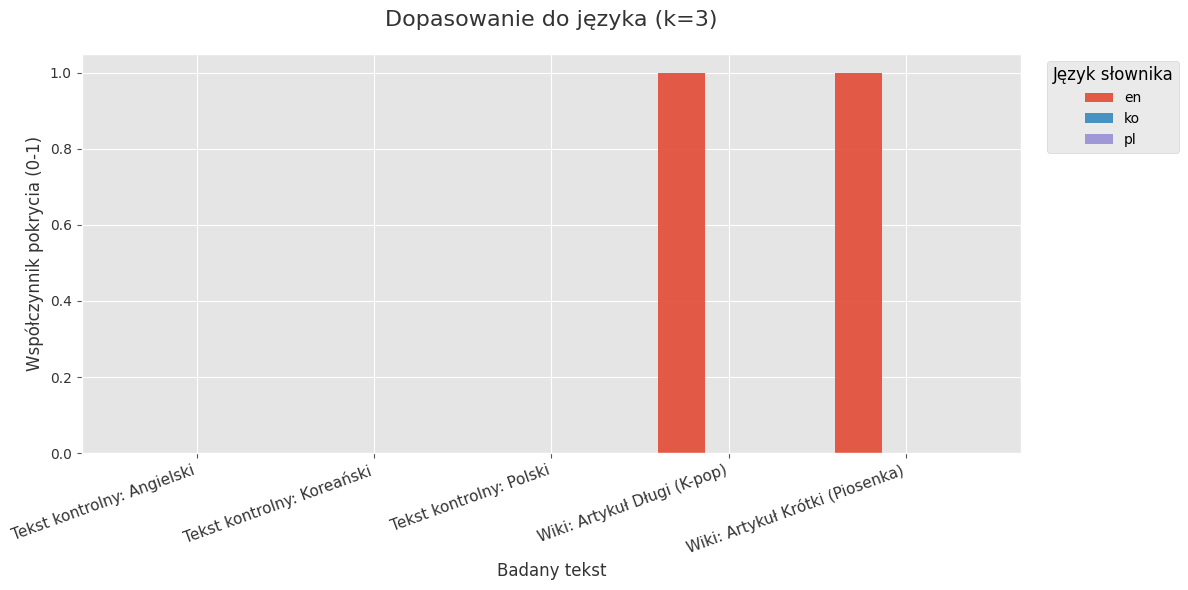

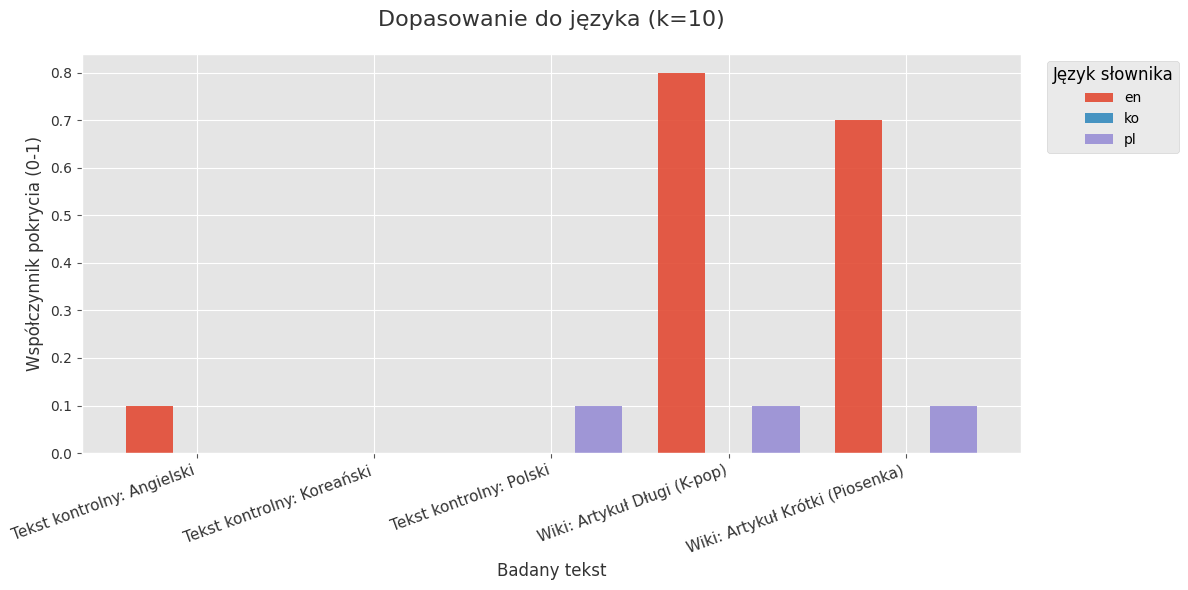

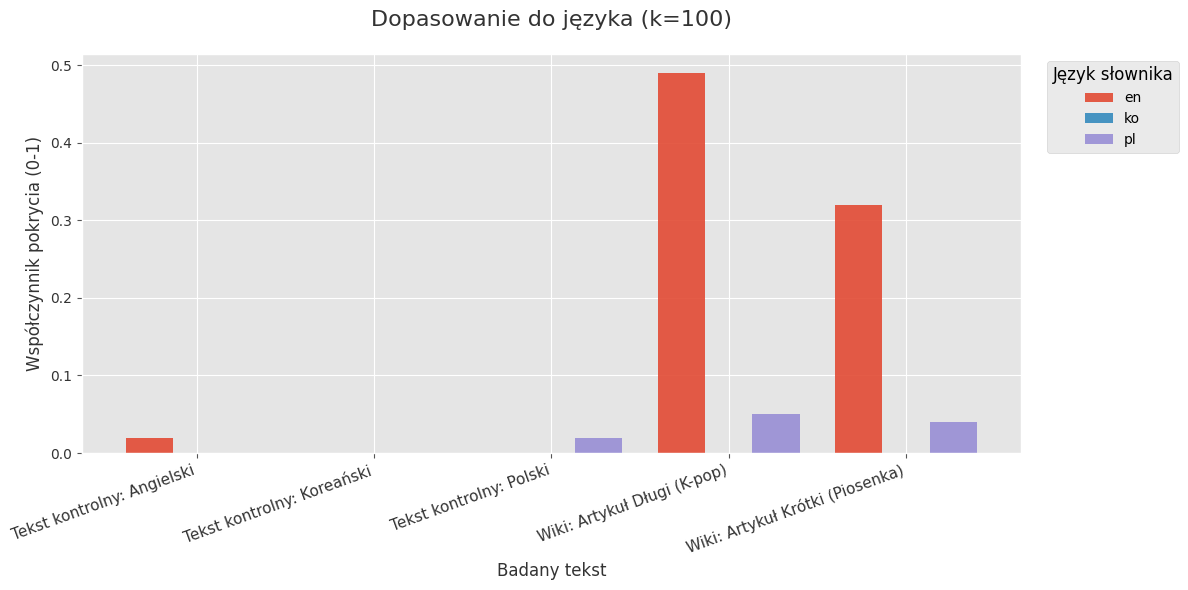

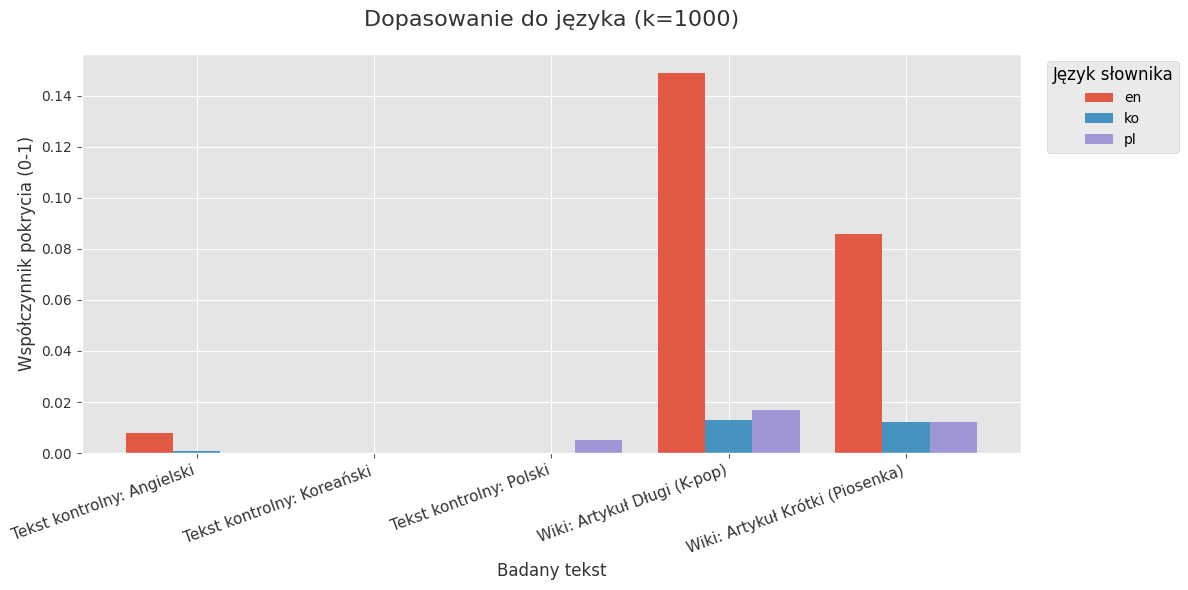

In [12]:
# Ustawiamy styl ciemny
plt.style.use('ggplot')

results = []

for sample_name, word_counts in samples.items():
    for k in k_values:
        for lang in languages:
            top_words = data_lang[lang][k]
            score = lang_confidence_score(word_counts, top_words)
            results.append({
                "Sample": sample_name,
                "k": k,
                "Language": lang,
                "Score": score
            })

df_res = pd.DataFrame(results)

# Rysowanie wykresów
for k in k_values:
    subset = df_res[df_res['k'] == k]
    pivot = subset.pivot(index="Sample", columns="Language", values="Score")

    # Tworzymy figurę
    fig, ax = plt.subplots(figsize=(12, 6))

    # Rysujemy słupki
    pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.9)

    # Tytuł i opisy
    text_color = '#333333'

    ax.set_title(f"Dopasowanie do języka (k={k})", fontsize=16, pad=20, color=text_color)
    ax.set_ylabel("Współczynnik pokrycia (0-1)", fontsize=12, color=text_color)
    ax.set_xlabel("Badany tekst", fontsize=12, color=text_color)

    # Oś X - obrót i dopasowanie
    plt.xticks(rotation=20, ha='right', fontsize=11, color=text_color)
    plt.yticks(color=text_color)

    # Legenda
    plt.legend(title="Język słownika", title_fontsize='12',
               bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Wnioski z analizy empirycznej

Na podstawie przeprowadzonych badań porównawczych dla języków: angielskiego (`en`), polskiego (`pl`) i koreańskiego (`ko`), dochodzimy do wniosków:

## 1. Skuteczność wykrywania języka Wiki
Metoda oparta na częstotliwości słów (**Word Frequency**) bezbłędnie zidentyfikowała język artykułów z *generasia.com*.
*   Zarówno dla **artykułu długiego**, jak i **krótkiego**, najwyższy współczynnik dopasowania uzyskano dla języka angielskiego.
* Niewielkie wartości dla języka polskiego przy analizie tekstu angielskiego wynikają z występowania międzyjęzykowych homografów – krótkich słów o identycznej pisowni, lecz innym znaczeniu (np. 'a', 'to', 'on', 'do'), które znajdują się na szczytach list frekwencyjnych w obu językach. To świadczy o tym, że metoda oparta na samych słowach (bez kontekstu) jest skuteczna, ale nie jest idealna.
* Scraper został skonfigurowany do obsługi znaków Unicode (`\w`), co pozwoliło na analizę alfabetu Hangul. Wynik dla języka koreańskiego (brązowy słupek) w artykułach Wiki jest niezerowy i poprawny. Wynika on z faktu, że artykuły o tematyce K-popowej zawierają **wstawki w języku oryginalnym** – np. imiona artystów czy tytuły piosenek.



## 2. Wpływ długości próbki (parametr k)
Wartość `k` (liczba najczęstszych słów branych do porównania) ma kluczowe znaczenie dla interpretacji wyników:
*   **Dla małego k:** Wyniki są wysokie dla wszystkich tekstów angielskich, ponieważ słowa takie jak *"the", "is", "a"* występują w prawie każdym zdaniu.
*   **Dla dużego k:** Wynik procentowy dla krótkich tekstów kontrolnych drastycznie spada. Jest to zjawisko naturalne – tekst mający 20 słów fizycznie nie jest w stanie pokryć 15% słownika składającego się z 1000 słów. Najlepiej wypada tu artukuł długi, który jako jedyny ma wystarczająco dużą objętość, by konkurować ze statystyką całego języka.

## 3. Problem fleksji i specyfika języka koreańskiego
Analiza pokazała wyraźne różnice w sposobie przetwarzania różnych rodzin językowych:
*   **Język Angielski:** Mamy do czynienia z dość prostą strukturą fleksyjną — odmian jest niewiele. Słowa występujące w tekście, na przykład *"music"*, często są takie same jak w słowniku, co przekłada się na wyższe wyniki dopasowania.
*   **Język Polski:** Ma bardziej rozbudowaną fleksję. Na przykład słowo w tekście, takie jak *"języka"*, różni się od formy podstawowej *"język"*. To powoduje, że wynik w porównaniu z angielskim jest niższy, bo system musi radzić sobie z odmianą.
*   **Język Koreański:** wypada najsłabiej w przeprowadzonych testach. Wszystko przez jego aglutynacyjny charakter, gdzie różne partykuły i końcówki są doklejane do rzeczowników. Prosty sposób podziału tekstu na elementy nie oddziela dobrze rdzenia słowa od dodatkowych końcówek. W praktyce oznacza to, że algorytm nie jest w stanie znaleźć odpowiedniego dopasowania w bazie `wordfreq`.

Można więc stwierdzić, że różnice w morfologii języków mają spory wpływ na skuteczność
przetwarzania w omawianym procesie. Dużo większe znaczenie w analizie miałoby to jednak gdyby artykuły były pisane we wszystkich 3 językach równomiernie.

## 4. Wpływ długości tekstu
Badanie potwierdziło, że przy wysokim parametrze $k=1000$ kluczowa dla wiarygodności metody jest długość tekstu. Krótkie próbki fizycznie nie są w stanie pokryć szerokiego zbioru odniesienia, co matematycznie wymusza niski wynik. Jedynie teksty o objętości zbliżonej lub większej od $k$ pozwalają na statystycznie miarodajną ocenę przynależności językowej.